# Part 3 - Plotting neutron lethargy energy spectra across a surface with a energy group structure

This example creates a simple sphere of water and tallies the neutrons crossing a surface:

We are also making use of an energy group structure for the spectrum instead of the linear energy group bins in the previous example.

Group structures provide a list of energy bins which are non uniformly spaced and this helps get details from the tally.

Current per unit lethargy is also plotted instead of 


In [ ]:
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/qHqAuqMLYPA", width=560, height=315)

This section creates a simple material, geometry and settings. This model is used in both the neutron current tally and the neutron flux tally.

In [1]:
import openmc
openmc.config['cross_sections'] = '/home/nuclearkid/openmc_conda/openmc_data/endfb80/endfb-viii.0-hdf5/cross_sections.xml'
# MATERIALS

# Due to the hydrogen content water is a very good neutron moderator
my_material = openmc.Material()
my_material.add_element('H', 1, percent_type='ao')
my_material.add_element('O', 2, percent_type='ao')
my_material.set_density('g/cm3', 1)

my_materials = openmc.Materials([my_material])


# GEOMETRY

# surfaces
inner_surface = openmc.Sphere(r=1)
mid_surface = openmc.Sphere(r=10)
# Currently it is not possible to tally on boundary_type='vacuum' surfaces
outer_surface = openmc.Sphere(r=20, boundary_type='vacuum')

# three cells of the same material
inner_cell = openmc.Cell(region=-inner_surface)
inner_cell.fill = my_material

mid_cell = openmc.Cell(region=-mid_surface & +inner_surface)
mid_cell.fill = my_material

outer_vessel_cell = openmc.Cell(region=+mid_surface & -outer_surface)
mid_cell.fill = my_material

my_geometry = openmc.Geometry([inner_cell,mid_cell, outer_vessel_cell])


# SIMULATION SETTINGS

# Instantiate a Settings object
my_settings = openmc.Settings()
my_settings.batches = 10
my_settings.particles = 200000
my_settings.run_mode = 'fixed source'

# Create a DT point source
my_source = openmc.IndependentSource()
my_source.space = openmc.stats.Point((0, 0, 0))
my_source.angle = openmc.stats.Isotropic()
my_source.energy = openmc.stats.Discrete([14e6], [1])
my_settings.source = my_source

This section section adds a tally for the average neutron flux across a cell.

In [2]:
#creates an empty tally object
my_tallies = openmc.Tallies()

# sets up filters for the tallies
neutron_particle_filter = openmc.ParticleFilter(['neutron'])

# creates an array of energy bins to use for the tally
# these are not linearly spaced as they have extra bins in key energy ranges
# A full list of energy structures is available here
# https://github.com/openmc-dev/openmc/blob/6254be37582e09acff038f5656332b89e53e4eae/openmc/mgxs/__init__.py#L50-L420
energy_filter = openmc.EnergyFilter.from_group_structure('CCFE-709')

# setup the filters for the cell tally
inner_surface_filter = openmc.SurfaceFilter(inner_surface)
mid_surface_filter = openmc.SurfaceFilter(mid_surface) 

# in openmc a surface current includes positive contributions from neutrons
# passing in one direction and negative contributions from neutrons passing
# in the other direction. A openmc.CellFromFilter can be used to get
# contributions from a single direction.

# create the tally
inner_surface_spectra_tally = openmc.Tally(name='inner_surface_spectra_tally')
inner_surface_spectra_tally.scores = ['current']
inner_surface_spectra_tally.filters = [inner_surface_filter, neutron_particle_filter, energy_filter]
my_tallies.append(inner_surface_spectra_tally)

mid_surface_spectra_tally = openmc.Tally(name='mid_surface_spectra_tally')
mid_surface_spectra_tally.scores = ['current']
mid_surface_spectra_tally.filters = [mid_surface_filter, neutron_particle_filter, energy_filter]
my_tallies.append(mid_surface_spectra_tally)

This section adds two surface current tallies - one on the inner sphere surface and one on the outer sphere surface.

This section runs the simulation.

In [3]:
# combine all the required parts to make a model
model = openmc.model.Model(my_geometry, my_materials, my_settings, my_tallies)

# remove old files and runs OpenMC
!rm *.h5
results_filename = model.run()

[juan-ASUS-TUF-Gaming-F15:13812] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.juan-ASUS-TUF-Gaming-F15.1000/jf.0/1473511424/shared_mem_cuda_pool.juan-ASUS-TUF-Gaming-F15 could be created.
[juan-ASUS-TUF-Gaming-F15:13812] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
          

This section extracts the cell tally data from the results file and plots neutron flux across the cell.

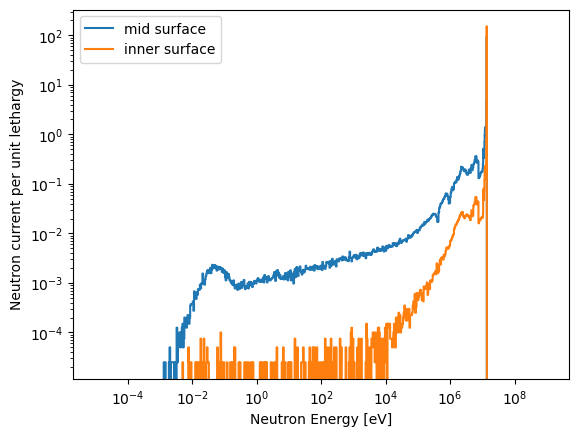

In [4]:
# open the results file
results = openmc.StatePoint(results_filename)

#extracts the tally values from the simulation results
inner_surface_tally = results.get_tally(name='inner_surface_spectra_tally')
mid_surface_tally = results.get_tally(name='mid_surface_spectra_tally')

# these are the widths of each energy bin (energy bins vary in size to get detail in specific areas of the spectrum)
bin_boundaries = energy_filter.lethargy_bin_width

inner_current = inner_surface_tally.mean.flatten()
mid_current = mid_surface_tally.mean.flatten()

normalised_inner_current = inner_current / bin_boundaries
normalised_mid_current = mid_current / bin_boundaries

import matplotlib.pyplot as plt
plt.figure()
plt.step(energy_filter.values[:-1], normalised_mid_current, label='mid surface')
plt.step(energy_filter.values[:-1], normalised_inner_current, label='inner surface')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylabel('Neutron current per unit lethargy')
plt.xlabel('Neutron Energy [eV]')
plt.show()

This section extracts the surface tally data from the results file and plots neutron current through the inner and outer surfaces.

#### Additional notes

- The current tally has a direction so particles can be +ve or -ve contributors.
- Sometimes an additional cellFromFilter is needed to detect the current in a certain direction.
- When comparing these results with other codes it might be necessary to scale them:
    - The OpenMC surface current needs to be divided by the surface area when comparing with MCNP.


**Learning Outcomes for Part 1:**

- Neutron spectra can be tallied in OpenMC using current tallies, and energy bins.
- Neutrons get moderated as they pass through a geometry and the thermal neutron distribution can be seen.
- To clearly identify the thermal neutron distribution extra energy bins are needed to resolve the structure.
- OpenMC has lots of group structure built in which can be accessed with the ```from_group_structure``` method

Can you think of a case where the neutron flux might increase in the first few cm of material, can you model it and show this to be the case